### Putting it all together with a multi-class classification 

* Binary Class Classification = one thing or another Cat vs Dog or Spam-NotSpam 
* Multi Class Classification = one thing or another or another such as cat or dog or chicken 

In [1]:
### Creating a toy multiclass dataset

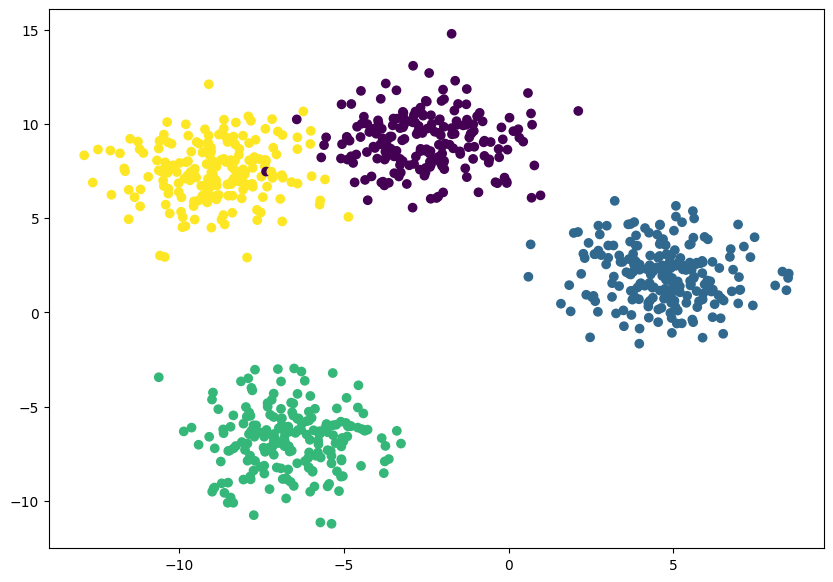

In [260]:
import torch
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyper parameters 
NUM_CLASSES = 4 
NUM_FEATIRES = 2
RANDOM_SEED = 42


# Create multiclass data 
X_blobs, y_blobs = make_blobs(n_samples=1000,
                              n_features=NUM_FEATIRES,
                              centers=NUM_CLASSES,
                              cluster_std=1.5,
                              random_state=RANDOM_SEED)

#* Turn data into Tensors 

X_blobs = torch.from_numpy(X_blobs).type(torch.float32)
y_blobs = torch.from_numpy(y_blobs).type(torch.LongTensor)


#* Split into train and test dat a
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
                                                                        X_blobs,y_blobs,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

#* Visualize the created toy dat 

plt.figure(figsize=(10,7))
plt.scatter(X_blob_train[:,0],X_blob_train[:,1],c= y_blob_train)

In [261]:
import pandas as pd 
values = pd.DataFrame({"X1":X_blob_train[:,0], "X2":X_blob_train[:,1],"label":y_blob_train})
values.head(15)

,X1,X2,label
0,5.040454,3.307616,1
1,-2.624850,9.526014,0
2,-8.524040,-9.040186,2
3,-6.026153,-4.437515,2
4,-3.339672,7.217469,0
5,0.775507,7.801839,0
6,-4.296153,9.999117,0
7,3.822500,2.571874,1
8,-7.646931,5.442089,3
9,-3.747443,8.532207,0


### Building a multi-class classification model in PyTorch

In [262]:
#* Creating device agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [263]:
from torch import nn

In [264]:
#* Build a multiclass classification model 
class BlobModel(nn.Module):
    def __init__(self,input_features, output_features, hidden_units=8):
        """Initialized multiclass classification models
        
        Args:
            input_features (int):Number of input features to the model 
            output_features (int): Number of output features from the model
            hidden_features (int): Number of hidden units between layers, default=8

        Returns:
        
        Example:
         
        """
        super().__init__()
        self.linear_layer_stacck = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features),
        )
        
        
    def forward(self,x):
        return self.linear_layer_stacck(x)
    
    
#* Create an instance of model and send it to the target device 
model = BlobModel(input_features=2,output_features=4,hidden_units=8).to(device)
model.state_dict

<bound method Module.state_dict of BlobModel(
  (linear_layer_stacck): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)>

### Select loss function and optimizer

In [265]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),lr=0.01)

### Build Training Loop 

In [266]:
X_blob_test.dtype

torch.float32

In [267]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test.to(device))

y_logits[:10]

#* In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction 
#* probabilities and then to prediction labels. 

#* Logits -> Pred Probs -> Pred Labels 

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [268]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [269]:
#* convert our models outputs to prediction probabilities 
y_pred_probs = torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])
print(y_blob_test[:5])


tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')
tensor([1, 3, 2, 1, 0])


In [270]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [271]:
torch.sum(y_pred_probs[1])

tensor(1., device='cuda:0')

In [272]:
torch.argmax(y_pred_probs[4])

tensor(0, device='cuda:0')

### Convert our model prediction probabilities to prediction labels 

In [273]:
y_pred = torch.argmax(y_pred_probs,dim=1)
print("Untrained model results:")
print((y_pred.to(device)).unsqueeze(dim=0) ==  (y_blob_test.to(device)).unsqueeze(dim=0))

Untrained model results:
tensor([[ True, False, False, False,  True, False, False,  True, False,  True,
          True,  True,  True,  True,  True, False, False, False, False, False,
         False,  True, False, False, False, False, False,  True, False,  True,
         False,  True, False, False,  True, False, False, False,  True, False,
          True, False, False, False,  True, False, False, False,  True,  True,
         False,  True, False, False, False, False, False,  True, False, False,
         False,  True, False, False, False,  True,  True, False, False,  True,
          True, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False, False,  True,  True, False, False,
          True,  True, False,  True, False, False, False,  True, False, False,
         False, False,  True, False, False, False,  True,  True, False, False,
         False, False,  Tru

### Creating a training loop and testing loop for a multi-class PyTorch model 

In [274]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [275]:
# Fit the multi class model to the data 
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

#* set number of epochs 
epochs = 3000

#* put data to the target device 
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    
    # switch model to train 
    model.train()
    
    #* forward pass 
    y_logits = model(X_blob_train)
    y_pred = torch.argmax(torch.softmax(y_logits,dim=1),dim=1)
    
    #* Loss Calculations 
    loss = loss_fn(y_logits,y_blob_train)

    #* calculate accuracy 
    acc = accuracy_fn(y_true=y_blob_train,y_pred=y_pred)
    
    #* optimizer zero grad 
    optimizer.zero_grad()
    
    #* backprobagation 
    loss.backward()
    
    #* optimizer step 
    optimizer.step()
    
    
    #* Testing the model 
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_blob_test)
        test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits,y_blob_test)
        
        test_acc = accuracy_fn(y_true=y_blob_test,y_pred=test_preds)
        
        
    
    #* Print out what is happening 
    if epoch % 10 == 0 :
        print(f'Epoch:{epoch} | Losss:{loss:.4f}, Train Acc:{acc:.2f}%  | Test Loss:{test_loss:.4f}, Test Acc:{test_acc:.2f}%')
            
    

Epoch:0 | Losss:1.1588, Train Acc:40.38%  | Test Loss:1.1472, Test Acc:38.50%
Epoch:10 | Losss:1.0649, Train Acc:55.38%  | Test Loss:1.0684, Test Acc:50.50%
Epoch:20 | Losss:0.9819, Train Acc:62.62%  | Test Loss:0.9976, Test Acc:57.50%
Epoch:30 | Losss:0.9114, Train Acc:70.50%  | Test Loss:0.9360, Test Acc:67.00%
Epoch:40 | Losss:0.8529, Train Acc:88.38%  | Test Loss:0.8834, Test Acc:87.50%
Epoch:50 | Losss:0.8043, Train Acc:92.12%  | Test Loss:0.8385, Test Acc:93.00%
Epoch:60 | Losss:0.7635, Train Acc:93.62%  | Test Loss:0.7998, Test Acc:94.50%
Epoch:70 | Losss:0.7285, Train Acc:94.88%  | Test Loss:0.7659, Test Acc:95.00%
Epoch:80 | Losss:0.6977, Train Acc:95.62%  | Test Loss:0.7356, Test Acc:95.00%
Epoch:90 | Losss:0.6698, Train Acc:96.38%  | Test Loss:0.7076, Test Acc:96.50%
Epoch:100 | Losss:0.6438, Train Acc:96.88%  | Test Loss:0.6812, Test Acc:97.00%
Epoch:110 | Losss:0.6191, Train Acc:97.62%  | Test Loss:0.6557, Test Acc:97.50%
Epoch:120 | Losss:0.5952, Train Acc:97.75%  | Test 

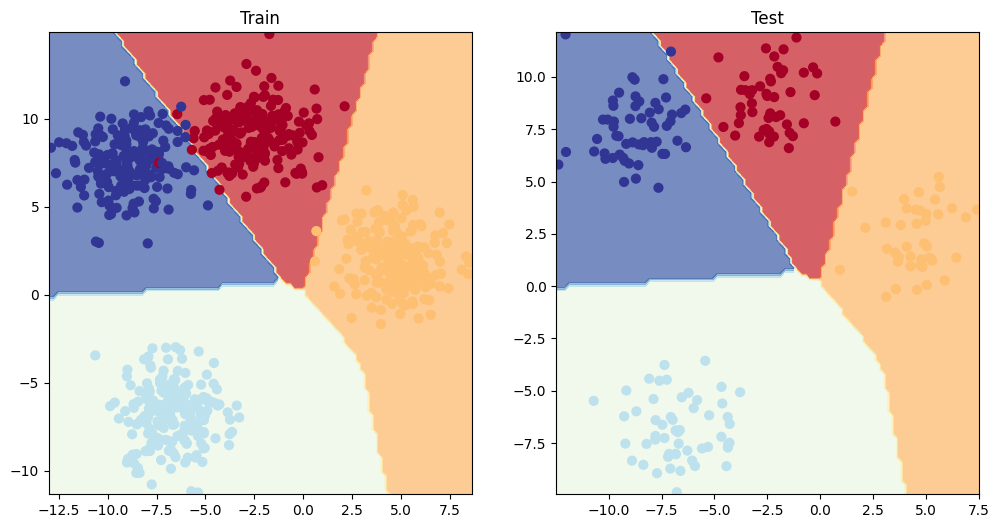

In [276]:
from helper_functions import plot_decision_boundary

# plot decision boundary of the model 
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model,X_blob_train,y_blob_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model,X_blob_test,y_blob_test)

### Making predictions and evaluating the model

In [277]:
model = model.to(device)

model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)
    
#* view the first 10 predictions 
y_logits[:10]
    

tensor([[ -1.1190,   8.2336,  -9.1021, -10.1315],
        [ -2.4767,  -7.7302,  -4.8981,   4.3520],
        [ -4.5598,  -4.9795,   4.3706,  -3.5110],
        [ -1.7879,   5.9161,  -4.7584,  -5.8486],
        [  5.3148,  -1.6618, -10.8214,  -8.3171],
        [ -3.1615,  -9.1873,  -5.6967,   5.2217],
        [ -4.0254,  -4.2684,   3.8312,  -2.9063],
        [  4.7522,  -5.1729,  -8.2824,  -4.1976],
        [ -5.8080,  -6.3643,   5.3609,  -4.5141],
        [  4.9848,  -3.8625,  -8.9898,  -5.5721]], device='cuda:0')

In [278]:
#* Go from logits -> Predictions Probabilities 
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[8.6728e-05, 9.9991e-01, 2.9589e-08, 1.0570e-08],
        [1.0809e-03, 5.6526e-06, 9.5984e-05, 9.9882e-01],
        [1.3223e-04, 8.6904e-05, 9.9940e-01, 3.7742e-04],
        [4.5083e-04, 9.9952e-01, 2.3116e-05, 7.7708e-06],
        [9.9907e-01, 9.3260e-04, 9.8117e-08, 1.2005e-06],
        [2.2862e-04, 5.5228e-07, 1.8117e-05, 9.9975e-01],
        [3.8647e-04, 3.0310e-04, 9.9813e-01, 1.1834e-03],
        [9.9982e-01, 4.8920e-05, 2.1831e-06, 1.2974e-04],
        [1.4105e-05, 8.0863e-06, 9.9993e-01, 5.1439e-05],
        [9.9983e-01, 1.4374e-04, 8.5276e-07, 2.6009e-05]], device='cuda:0')

In [279]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [280]:
y_preds = y_pred_probs.argmax(dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

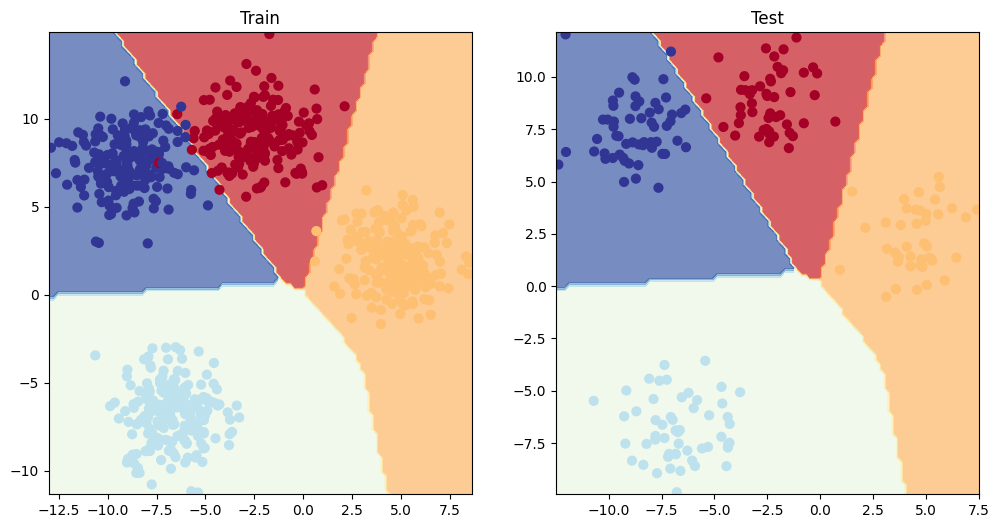

In [281]:

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model,X_blob_train,y_blob_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model,X_blob_test,y_blob_test)


### A few more classification metrics 

* Accuracy - out of 100 samples, how many our models get right 
* Precision 
* Recall 
* F1 Score 
* Confusion Matrix 
* Classification report 

In [283]:
!pip install torchmetrics

   ---------------------------------------- 0.0/840.2 kB ? eta -:--:--
   - -------------------------------------- 30.7/840.2 kB 1.4 MB/s eta 0:00:01
   ----- ---------------------------------- 122.9/840.2 kB 1.4 MB/s eta 0:00:01
   ------------- -------------------------- 286.7/840.2 kB 2.2 MB/s eta 0:00:01
   ------------------------------ --------- 634.9/840.2 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 840.2/840.2 kB 4.1 MB/s eta 0:00:00


In [284]:
from torchmetrics import Accuracy

In [291]:
# Setup metrics 
torchmetrics_accuracy = Accuracy(task='CLA')

# Calculate accuracy 
torchmetrics_accuracy(y_preds,y_blob_test)

ValueError: Invalid Classification: expected one of ['BINARY', 'MULTICLASS', 'MULTILABEL'], but got CLA.

In [287]:
metric = Accuracy()
metric.attach(model, "accuracy")
y_true = torch.tensor([1, 0, 1, 1, 0, 1])
y_pred = torch.tensor([1, 0, 1, 0, 1, 1])
state = default_evaluator.run([[y_pred, y_true]])
print(state.metrics["accuracy"])

TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'

### Save The model

In [123]:
from pathlib import Path

#* create model's directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)


#* Create model's save path 
MODEL_NAME = "02_non_linear_multiclass_classification_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


#* Save the model_state_dict 
print(f'model saving to {model.state_dict(),MODEL_SAVE_PATH}')
torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)

model saving to (OrderedDict([('linear_layer_stacck.0.weight', tensor([[-0.1618, -0.8796],
        [ 1.0302,  0.0234],
        [-1.0208, -0.7066],
        [ 0.1713, -0.5517],
        [ 0.4001,  0.1822],
        [ 1.0135, -0.3413],
        [ 0.0243,  0.0254],
        [-0.3364,  0.6868]])), ('linear_layer_stacck.0.bias', tensor([-0.1287, -0.0846,  0.5449, -0.5061, -0.5386,  0.5373, -0.2519,  0.5731])), ('linear_layer_stacck.2.weight', tensor([[-5.2748e-01,  3.6206e-01,  3.0811e-01, -1.2173e-01,  2.9747e-01,
         -2.4875e-05,  5.7963e-02,  1.0494e-01],
        [ 5.4381e-01,  1.4479e-01,  3.7421e-01, -5.2153e-02,  8.8856e-02,
         -2.5476e-02,  2.5846e-01, -5.3257e-01],
        [-1.1054e-01,  6.0933e-01,  2.6310e-02, -8.1148e-02,  2.4279e-01,
          5.7609e-01, -1.0665e-01, -5.6970e-02],
        [-2.5064e-01,  4.1466e-01, -1.0829e-01,  2.0082e-01, -1.9063e-01,
          5.7258e-01,  1.1216e-01,  2.1650e-02],
        [-1.3319e-01,  1.6164e-01, -2.4071e-01, -2.8204e-01, -4.8895e-0